In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchinfo
from torchinfo import summary
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import pathlib
from pathlib import Path
from typing import Dict, List
import random
from PIL import Image
from tqdm.auto import tqdm
from timeit import default_timer as timer 

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

####  Inspecting what's in our base directory 
By writing a small helper function to **walk through** each of the subdirectories and count the files present.

In [2]:
base_dir = "/kaggle/input/nike-adidas-and-converse-imaged"
def walk_through_dir(dir_path):
     for dirpath, dirnames, filenames in os.walk(dir_path):
             print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
                
                
walk_through_dir(base_dir)

There are 2 directories and 0 images in '/kaggle/input/nike-adidas-and-converse-imaged'.
There are 3 directories and 0 images in '/kaggle/input/nike-adidas-and-converse-imaged/test'.
There are 0 directories and 38 images in '/kaggle/input/nike-adidas-and-converse-imaged/test/converse'.
There are 0 directories and 38 images in '/kaggle/input/nike-adidas-and-converse-imaged/test/nike'.
There are 0 directories and 38 images in '/kaggle/input/nike-adidas-and-converse-imaged/test/adidas'.
There are 3 directories and 0 images in '/kaggle/input/nike-adidas-and-converse-imaged/train'.
There are 0 directories and 237 images in '/kaggle/input/nike-adidas-and-converse-imaged/train/converse'.
There are 0 directories and 237 images in '/kaggle/input/nike-adidas-and-converse-imaged/train/nike'.
There are 0 directories and 237 images in '/kaggle/input/nike-adidas-and-converse-imaged/train/adidas'.


#### Exploring the Train Directory
1. We can see that there are only 3 class labels of show brand images namely; **[converse, nike and adidas.]**

In [4]:
test_dir = "/kaggle/input/nike-adidas-and-converse-imaged/test"
train_dir = "/kaggle/input/nike-adidas-and-converse-imaged/train"

class_names = os.listdir(train_dir)
num_classes = len(class_names)
print(f'Number of classes : {num_classes}\nClasses : {class_names}')

Number of classes : 3
Classes : ['converse', 'nike', 'adidas']


#### Visualizing 4 samples from each class labels of the shoe brand images.

Shoe Brand Row 1 : converse
Shoe Brand Row 2 : nike
Shoe Brand Row 3 : adidas


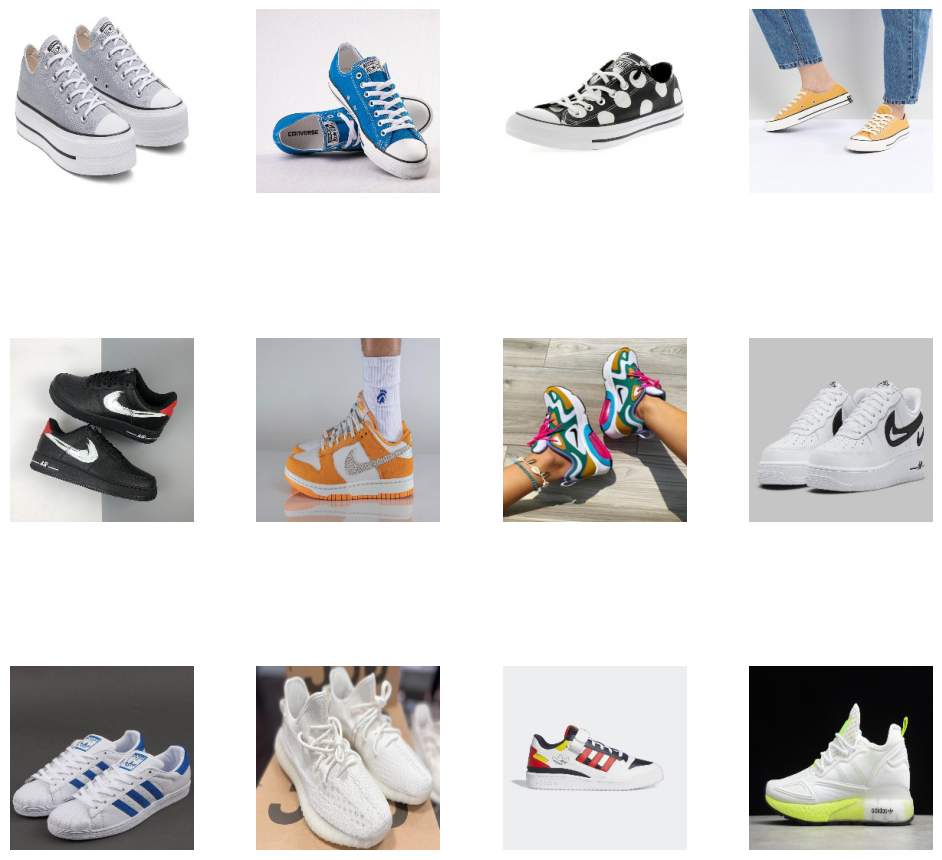

In [5]:
samples = []

for i in class_names:
    images = os. listdir(os.path.join(base_dir,"train",i))
    for j in images [:4]:
        samples.append(np.asarray(Image.open(os.path.join(base_dir,'train',i,j))))
    
fig, axes = plt.subplots(nrows=3, ncols=4, figsize= (10, 10) )
fig.tight_layout()
idx = 0
for i in range(num_classes):
    print (f'Shoe Brand Row {i+1} : {class_names[i]}')
    for j in range(4):
        axes[i, j].imshow(samples[idx])
        axes[i, j].axis("off")
        idx+=1


#### Data Transformation and Augmentation
Before we can use our image data with PyTorch we need to turn it into tensors (numerical representations of our images) and also perform other kinds of transformations such as **Resizing**, **Flipping** and so on or **Random Transforms**.

In [31]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5,contrast=0.9,saturation=0.3,hue=0.5),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.9),
    transforms.RandomRotation(45),
    transforms.ToTensor()                                   # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

#### Visualizing random Transformed Images vs Original Images
I shall first get all Image Paths so as to find all images which in our case, end with **jpg**, then sample 3 random images, apply the **trains_transforms** and plot them beside their original form.

In [32]:
base_dir = Path("/kaggle/input/nike-adidas-and-converse-imaged")
baseImage_path_list = list(base_dir.glob("*/*/*.jpg"))

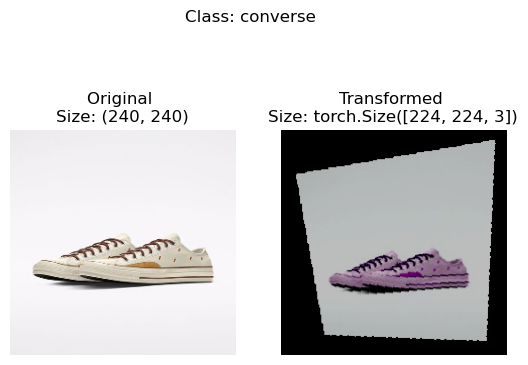

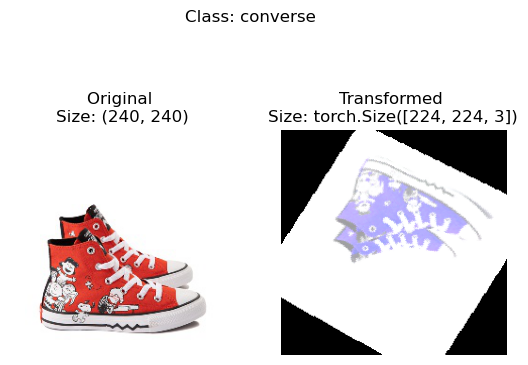

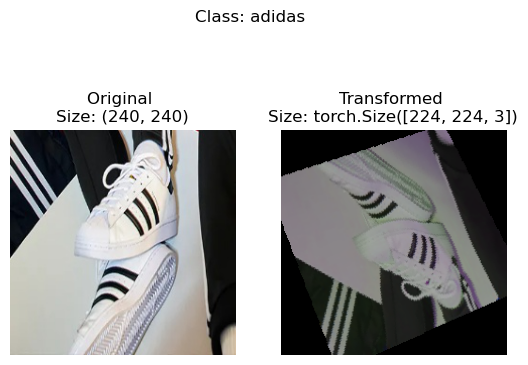

In [35]:
def plot_transformed_images(image_paths, transform, n=3):
    random_image_paths = random.choices(image_paths, k=n)
    for base_dir in random_image_paths:
        with Image.open(base_dir) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0)                        # Applying permute() will change shape of image to suit matplotlib 
            ax[1].imshow(transformed_image)                                          #(PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {base_dir.parent.stem}", fontsize=12)

plot_transformed_images(baseImage_path_list, 
                        transform=train_transforms, 
                        n=3)

### Loading Shoe brand images into the form of Dataset,
capable of being used with PyTorch.
Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`.

In [37]:
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=train_transforms, 
                                  target_transform=None) 

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=test_transforms)

class_names = train_data.classes
class_dict = train_data.class_to_idx
len(train_data), len(test_data)

print(f"Class names: {class_names}\nClass names and indexes: {class_dict}\nLength of Train data: {len(train_data)}\nLength of Test data: {len(test_data)}")

Class names: ['adidas', 'converse', 'nike']
Class names and indexes: {'adidas': 0, 'converse': 1, 'nike': 2}
Length of Train data: 711
Length of Test data: 114


#### Turning Image Datasets into **DataLoader's**.
Using `torch.utils.data.DataLoader`.

Turning our Dataset's into DataLoader's makes them **iterable** so a model can go through learn the relationships between samples and targets (features and labels).

In [40]:
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()  # It defines how many subprocesses will be created to load your data.
                              # more compute power PyTorch will use to load your data
    
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) 

# Check the shapes of a batch of Image
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([8, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


### Creating a Model Class

In [45]:
class TinyVGG(nn.Module):
   
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=2, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*57*57,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

model = TinyVGG(input_shape=3,                                           # number of color channels (3 for RGB) 
                  hidden_units=32, 
                  output_shape=len(class_names)).to(device)
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=103968, out_features=3, bias=True)
  )
)

### Test the Model to ensure that the hidden_units in the classifier layer is correct.
It's also handy way to test the input and output shapes of our different layers.
1. Get a single Image batch from the DataLoader.
2. Try a forward pass on the single Image batch.

The first time I ran the cell below, I got a shape error in the classifier layer. I then changed the number of hidden_units in the classifier layer so as to satify the rules of matrix multiflication, rerun the class model and cell below again and got no error.

In [44]:
img_batch, label_batch = next(iter(train_dataloader))
model(img_batch.to(device))

torch.Size([8, 32, 113, 113])
torch.Size([8, 32, 57, 57])
torch.Size([8, 3])


tensor([[ 0.0028,  0.0185,  0.0362],
        [ 0.0101,  0.0265,  0.0297],
        [ 0.0085,  0.0268,  0.0418],
        [-0.0001,  0.0123,  0.0324],
        [ 0.0082,  0.0236,  0.0361],
        [ 0.0054,  0.0326,  0.0341],
        [ 0.0112,  0.0297,  0.0334],
        [ 0.0100,  0.0337,  0.0349]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

#### Create train & test loop functions
To train our model on the training data and evaluate our model on the testing data.
I'll functionize them to make sure we can use these training and testing loops again,

Specifically, we're going to make three functions:

1. **train_step()** - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
2. **test_step()**- takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
3. **train()** - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

Because we're dealing with batches in the DataLoader's, we'll accumulate the model loss and accuracy values during training (by adding them up for each batch) and then adjust them at the end before we return them.

In [46]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    
    model.train()
    train_loss, train_acc = 0, 0
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [47]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [49]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results       

#### Train and Evaluate our Model 
Then call our **train()** function passing in the necessary parameters.
To keep our experiments quick, we'll train our model for 10 epochs.

As for an optimizer and loss function, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of 1e-3 respecitvely.

**However, It looks like our model performed pretty poorly with both train and test accuracy of around 30% - 35% and both the losses decreased very slightly**.


In [51]:
# Set number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model 
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2489 | train_acc: 0.3104 | test_loss: 1.0986 | test_acc: 0.3667
Epoch: 2 | train_loss: 1.1001 | train_acc: 0.3206 | test_loss: 1.0997 | test_acc: 0.3167
Epoch: 3 | train_loss: 1.0991 | train_acc: 0.3192 | test_loss: 1.0987 | test_acc: 0.3250
Epoch: 4 | train_loss: 1.0999 | train_acc: 0.3385 | test_loss: 1.0994 | test_acc: 0.3167
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3276 | test_loss: 1.0987 | test_acc: 0.3167
Epoch: 6 | train_loss: 1.0988 | train_acc: 0.3122 | test_loss: 1.0987 | test_acc: 0.3250
Epoch: 7 | train_loss: 1.0988 | train_acc: 0.3274 | test_loss: 1.0986 | test_acc: 0.3250
Epoch: 8 | train_loss: 1.0989 | train_acc: 0.3248 | test_loss: 1.0984 | test_acc: 0.4083
Epoch: 9 | train_loss: 1.0989 | train_acc: 0.3178 | test_loss: 1.0985 | test_acc: 0.3583
Epoch: 10 | train_loss: 1.0994 | train_acc: 0.3289 | test_loss: 1.0981 | test_acc: 0.3667
Total training time: 68.127 seconds


#### Model Evaluation using loss curves
Loss curves show the model's results over time and they're a great way to see how your model performs on different datasets (e.g. training and test).

We'll need to extract each ofour **model's keys (['train_loss', 'train_acc', 'test_loss', 'test_acc'])** and turn them into a plot.

Conclusion: The metrics go up and down sharply.

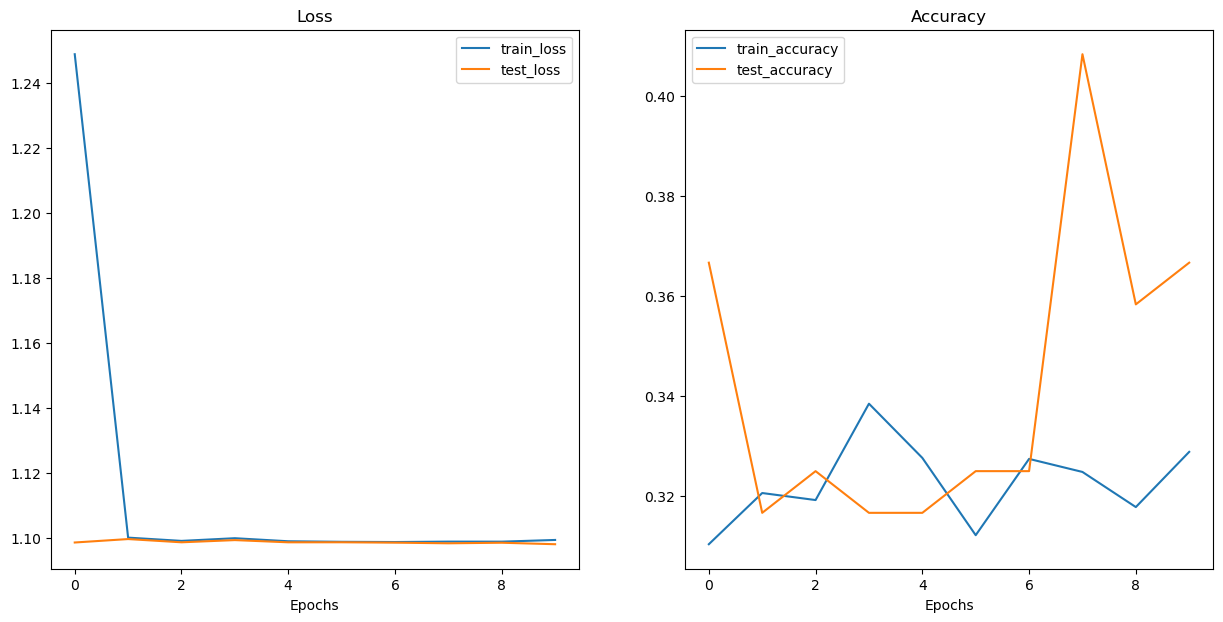

In [52]:
def plot_loss_curves(results: Dict[str, List[float]]): 
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    
plot_loss_curves(model_results)